In [49]:
from cytoflow import *
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import math
import random
import time
import iteration_utilities
import tqdm
import itertools
import fcsparser

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", { "xtick.major.size": 4, "ytick.major.size": 4, "font_color":'k', 'axes.edgecolor': 'k', 'xtick.color': 'k', 'ytick.color': 'k'})
sns.set_context("talk", font_scale=1.0)

# Defining tube loading function

In [50]:
plasmid_dict = { # maps plasmid number => plasmid name
#     57 : "ZIK1 KRAB + ZNF10 KRAB",    58 : "ZIK1 KRAB + FOXO3 TAD",
    59 : "ZIK1 KRAB + Rand Ctrl 89",  #60 : "KMT2C Dual + ZNF10 KRAB",
    61 : "KMT2C Dual + FOXO3 TAD",    #62 : "KMT2C Dual + Rand Ctrl 89",
    63 : "KMT2D Dual + ZNF10 KRAB",   #64 : "KMT2D Dual + FOXO3 TAD",
    65 : "KMT2D Dual + Rand Ctrl 89", 66 : "NCOA1 Dual + ZNF10 KRAB",
    67 : "NCOA1 Dual + FOXO3 TAD",    68 : "NCOA1 Dual + Rand Ctrl 89",
    69 : "NCOA2 Rep + FOXO3 TAD",     #70 : "Rand Ctrl + NCOA2 Act",
    #71 : "NCOA2 Rep + NCOA2 Act",     
    72 : "Rand Ctrl + Rand Ctrl 89",
    
    74 : "DMD - DMD",     75 : "DMD - RANDCTRL",      76 : "ZNF10 - ANM2",
    77 : "ZNF10 - CBX1",  78 : "RANDCTRL - RANDCTRL", 79 : "ANM2 - KIBRA",
    80 : "BIN1 - FOXO3",  81 : "CACO1 - ANM2",        82 : "CREM - MPP8",
    83 : "DPF1 - HSF2",   84 : "DPY30 - HXA13",       #85 : "FOXO3 - ZNF10",
    #86 : "IKKA - ANM2",   
    87 : "MPP8 - ZNF791", #88 : "MYBA - FOXO3",
    #89 : "NCOA2 - HXA13", 
    90 : "NOTC2 - ANM2",        91 : "NOTC2 - KIBRA",
    92 : "SMCA2 - U2AF4", 93 : "SUMO3 - SSX2",        94 : "YAF2 - ZNF791",
    #95 : "HES2 - NCOA2",  
    96 : "ATRX - HERC2",        97 : "SCML2 - NOTC2",
    98 : "CHD4 - CDYL2",  99 : "SMN2 - FOXO3",       
    
    126 : "rTetR only",  217 : "KRAB only",          144 : "MYB only"
}

plasmid_numbers = sorted(list(plasmid_dict.keys()))
plasmid_names = [plasmid_dict[p] for p in plasmid_numbers]

In [51]:
days = [0, 1, 2, 3, 4, 5, 6, 8, 11, 13, 15, 18, 20]
treatments = ["none", "DMSO", "9-c-RA"]
dox_doses = [0, 1000]
replicates = [1, 2]

In [52]:
letters = ["A", "B", "C", "D", "E", "F", "G", "H"]
numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

def get_treatment_list(plasmid):
    if plasmid in [66, 67, 68, 69]:
        return ["DMSO", "9-c-RA"]
    if plasmid in [126, 217]:
        return ["none", "DMSO", "9-c-RA"]
    return ["none"]

def get_tube_location_d0(plasmid, treatment, replicate):
    layout = [
        [59, 61, 63, 64, 65, 66],
        [67, 68, 69, 70, 71, 72],
        [74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 87],
        [88, 89, 90, 91, 92, 93],
        [94, 95, 96, 97, 98, 99],
        [126, 217, 144]
    ]
    
    for row in layout:
        if plasmid in row:
            r = layout.index(row)
            c = row.index(plasmid) + 6 * (1-replicate)
            return letters[r] + str(numbers[c])

def get_tube_location(plasmid, treatment, replicate):
    treatment_row = [66, 67, 68, 69, 126, 217]
    if plasmid in treatment_row and treatment != "none":
        row = 1 if treatment == "DMSO" else 2
        col = 1 + treatment_row.index(plasmid) + 6 * (1 - replicate)
        return letters[row-1] + str(numbers[col-1])
    
    rows = [
        [59,  61,  63,  65],
        [72, 126, 217, 144],
        
        [74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 87],
        [90, 91, 92, 93, 94, 96],
        [97, 98, 99]
    ]
    four_one = [59, 61, 63, 65]
    four_two = [72, 126, 217, 144]
    
    for row in rows:
        if plasmid in row:
            r = letters[rows.index(row) + 2]
            c = row.index(plasmid) + 1 + 6 * (1-replicate)
            return r + str(numbers[c-1])

In [53]:
tube_dir_dict = {
    0 : {
        0    : 'axm-20211111_d0dox_jt039-20211111-1942',
        1000 : 'axm-20211111_d0dox_jt039-20211111-1942'
    },
    1 : {
        0    : 'axm-20211112_d1_nodox_jt039-20211112-1855',
        1000 : 'axm-20211112_d1_dox_jt039-20211112-1825'
    },

    2 : {
        0    : 'axm-20211113_d2_nodox_jt039-20211113-1704',
        1000 : 'axm-20211113_d2_dox_jt039-20211113-2007'
    },

    3 : {
        0    : 'axm-20211114_d3_nodox_jt039-20211114-1654',
        1000 : 'axm-20211114_d3_dox_jt039-20211114-1724'
    },

    4 : {
        0    : 'axm-20211115_d4_nodox_jt039-20211115-1637',
        1000 : 'axm-20211115_d4_dox_jt039-20211115-1716'
    },

    5 : {
        0    : 'axm-20211116_d5_nodox_jt039-20211116-1632',
        1000 : 'axm-20211116_d5_dox_jt039-20211116-1709'
    },
    6 : {
        1000 : 'axm-20211117_d6_dox_jt039-20211117-1604',
        0 : 'axm-20211117_d6_nodox_jt039-20211117-1640'},
    8 : {
        1000 : 'axm-20211119_d8_dox_jt039-20211119-1659',
        0 : 'axm-20211119_d8_nodox_jt039-20211119-1623'},
    11 : {
        1000 : 'axm-20211122_d11_dox_jt039-20211122-1652',
        0 : 'axm-20211122_d11_nodox_jt039-20211122-1611'},
    13 : {
        1000 : 'axm-20211124_d13_dox_jt039-20211124-1615',
        0 : 'axm-20211124_d13_nodox_jt039-20211124-1539'},
    15 : {
        1000 : 'axm-20211126_d15_dox_jt039-20211126-1616',
        0: 'axm-20211126_d15_nodox_jt039-20211126-1540'},
    18 : {
        1000 : 'axm-20211129_d18_dox_jt039-20211129-1648',
        0 : 'axm-20211129_d18_nodox_jt039-20211129-1607'
    },
    20 : {
        1000 : 'axm-20211201_d20_dox_jt039-20211201-1614',
        0 : 'axm-20211201_d20_nodox_jt039-20211201-1536'
    }
}

In [54]:
def get_tube_file(day, dox, plasmid, treatment, replicate):
    # first, get folder location
    filedir = './data'
    folder = tube_dir_dict[day][dox]
    filedir = filedir + '/' + folder
    
    # get tube location
    tubename = get_tube_location_d0(plasmid, treatment, replicate) if day == 0\
                else get_tube_location(plasmid, treatment, replicate)
    
    # there we go
    return filedir + '/' + tubename + '.fcs'

# Importing tubes

In [55]:
tubeslist = []

for day in [0, 1, 2, 3, 4, 5, 6, 8, 11, 13, 15, 18, 20]:
    for dox in [0, 1000]:
        for plasmid in plasmid_dict:
            for treatment in get_treatment_list(plasmid):
                for replicate in [1, 2]:
                    #print(day, dox, plasmid, treatment, replicate)
                    tubeslist.extend([
                        Tube(conditions = {'plasmid' : plasmid,
                                           'description' : plasmid_dict[plasmid],
                                           'day' : day,
                                           'dox' : dox,
                                           'treatment' : treatment,
                                           'replicate' : replicate},
                            file = get_tube_file(day, dox, plasmid, treatment, replicate),
                            conditions_list = ['plasmid', 'description', 'day',
                                               'dox', 'treatment', 'replicate'])])

print("Loaded", len(tubeslist), "tubes")

Loaded 2132 tubes


In [56]:
# We have to do this the kind of stupid way 
# Let's try chunking..

tls = tubeslist

def get_ex0(chunk):
    op0 = ImportOp(
        conditions = {'plasmid'     : 'category',
                      'description' : 'category',
                      'day'         : 'float',
                      'dox'         : 'float',
                      'treatment'   : 'category',
                      'replicate'   : 'float'},
        tubes = chunk,
        channels={'mCitrine-A':'mCitrine-A',
                  'mCherry-A':'mCherry-A',
                  'FSC 488/10-A':'FSC 488/10-A',
                  'SSC 488/10-A':'SSC 488/10-A'})
    ex0 = op0.apply()
    return ex0


ex0_list = [get_ex0(list(chunk)) 
            for chunk in tqdm.notebook.tqdm(iteration_utilities.grouper(tls, 1), 
                                            position = 0, leave = True, total = len(tls))]

ex0 = ex0_list[0]
all_data = pd.concat([e.data for e in tqdm.notebook.tqdm(ex0_list)])
ex0.data = all_data
ex0.data.head()

  0%|          | 0/2132 [00:00<?, ?it/s]

  0%|          | 0/2132 [00:00<?, ?it/s]

,FSC 488/10-A,SSC 488/10-A,day,description,dox,mCherry-A,mCitrine-A,plasmid,replicate,treatment
0,8.317540e+08,219492864.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,14387968.0,85923072.0,59,1.0,none
1,4.958666e+08,180896512.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,104767232.0,66599936.0,59,1.0,none
2,4.226458e+08,101837056.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,26209536.0,61377280.0,59,1.0,none
3,1.038254e+09,372244224.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,365425920.0,376630272.0,59,1.0,none
4,8.091105e+08,349765120.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,180713472.0,1863680.0,59,1.0,none


# Live Gate

CPU times: user 10min 17s, sys: 2min 29s, total: 12min 46s
Wall time: 7min 1s


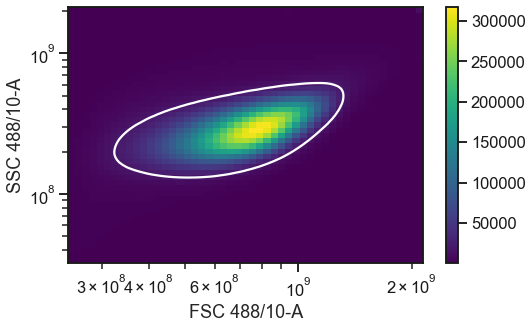

In [57]:
%%time

dens_op = DensityGateOp(
    name = 'P1',
    xchannel='FSC 488/10-A',
    xscale = 'log',
    ychannel='SSC 488/10-A',
    yscale = 'log',
    keep = 0.9)

dens_op.estimate(ex0)
ex1 = dens_op.apply(ex0)
dens_op.default_view().plot(ex0, height = 5)

# mCherry Gate

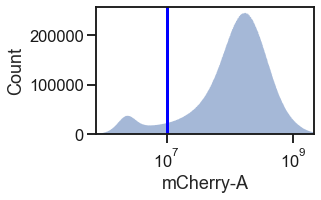

In [58]:
op_2 = ThresholdOp(
    name='mCherry', threshold=1e7, channel='mCherry-A')
ex_2 = op_2.apply(ex1)
op_2.default_view(
    subset='(P1==True)', scale='log').plot(ex_2)

In [59]:
ex_2.data.to_csv('./data/all_cells_live_mch_gated.csv', index = False)